In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from pymongo import MongoClient
import time
import datetime
import os
from pyculiarity import detect_ts
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from dendrogram_class import Dendrogram, make_dendrogram, mask_mins
import pickle
import itertools
from collections import defaultdict, Counter
import scipy.stats as scs
from scipy import signal
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, silhouette_samples
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

In [215]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
with open('data/csgo_features.pkl', 'rb') as f:
    df = pickle.load(f)

In [217]:
df.head()

,app,date,item_name,median_sell_price,quantity,release_date,parenthetical,gun_bool,StatTrak,souvenir,gun_type,skin,quality,keys,capsules,stickers,event_item,days_since_release
0,730,1.471583e+09,Glock-18 | Weasel (Battle-Scarred),6.193,135,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,0
1,730,1.471669e+09,Glock-18 | Weasel (Battle-Scarred),5.103,166,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,1
2,730,1.471756e+09,Glock-18 | Weasel (Battle-Scarred),4.721,142,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,2
3,730,1.471842e+09,Glock-18 | Weasel (Battle-Scarred),4.302,98,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,3
4,730,1.471928e+09,Glock-18 | Weasel (Battle-Scarred),3.898,125,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,4


In [219]:
df.release_date.unique()

array(['18 August 2016', '17 February 2016', '27 April 2016', nan,
       '26 May 2015', '14 September 2017', '8 December 2015',
       '15 April 2015', '15 March 2017', '20 February 2014',
       '28 November 2016', '27 November 2013', '18 December 2013',
       '17 September 2015', '15 June 2016', '1 May 2014',
       '15 February 2018', '8 January 2015', '14 August 2013',
       '8 November 2013', '23 May 2017', '1 July 2014', '8 August 2014',
       '19 September 2013', '11 November 2014', '12 February 2014',
       '10 July 2014'], dtype=object)

In [220]:
df['num_sale_days'] = df.groupby('item_name')['days_since_release'].transform('max')
df['desc'] = df['item_name'] + ' ' + df['release_date']
# df_pivot = df_sub.reset_index().pivot('desc', 'num_sales_days', 'median_sell_price')

In [221]:
den = Dendrogram()
den.fit(df)

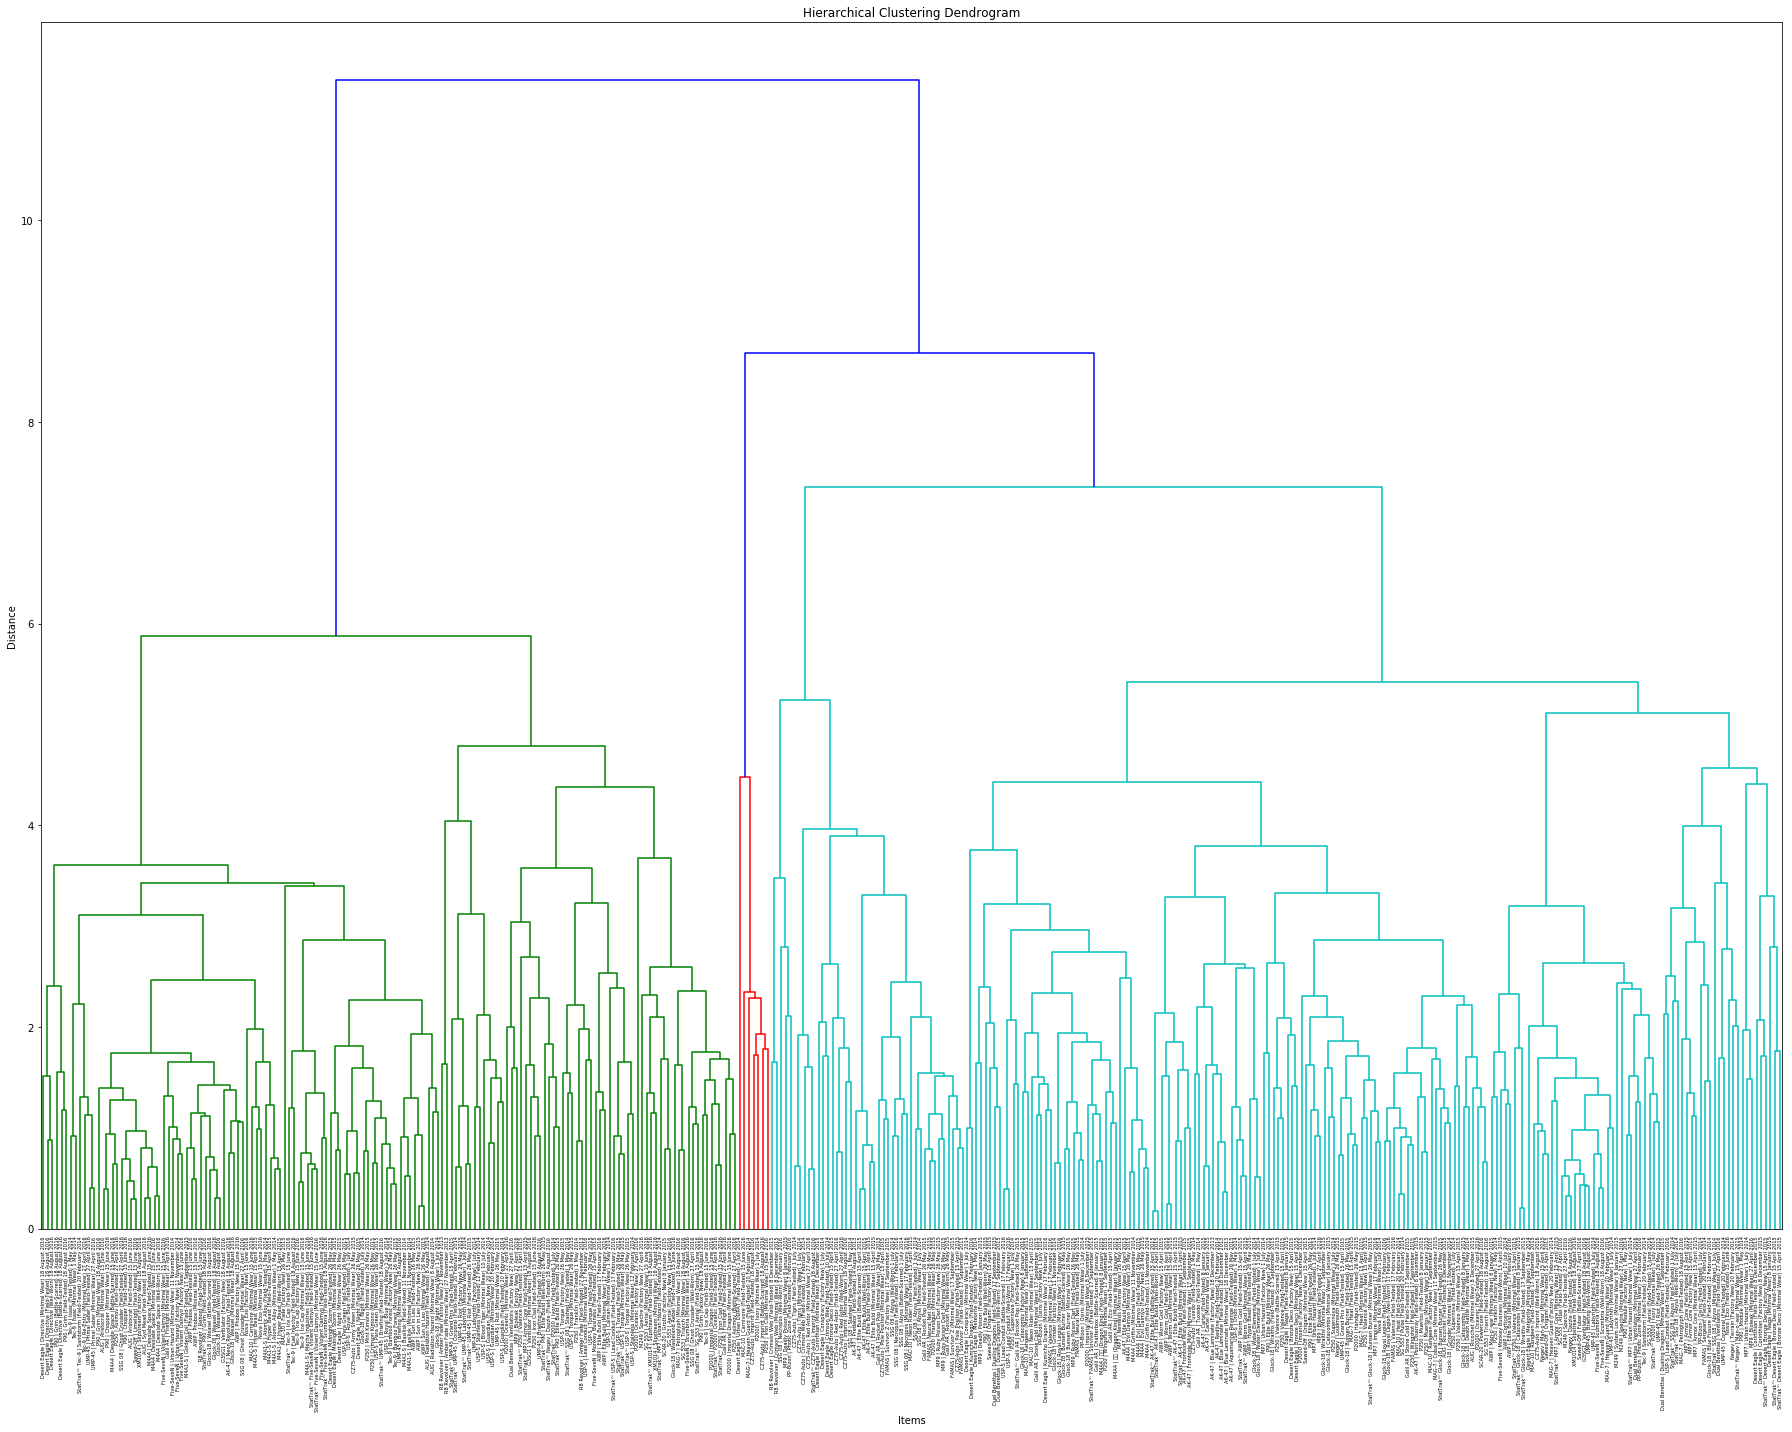

In [222]:
den.make_dendrogram(save=True)

### These two items were tightly clustered but weren't released on the same day

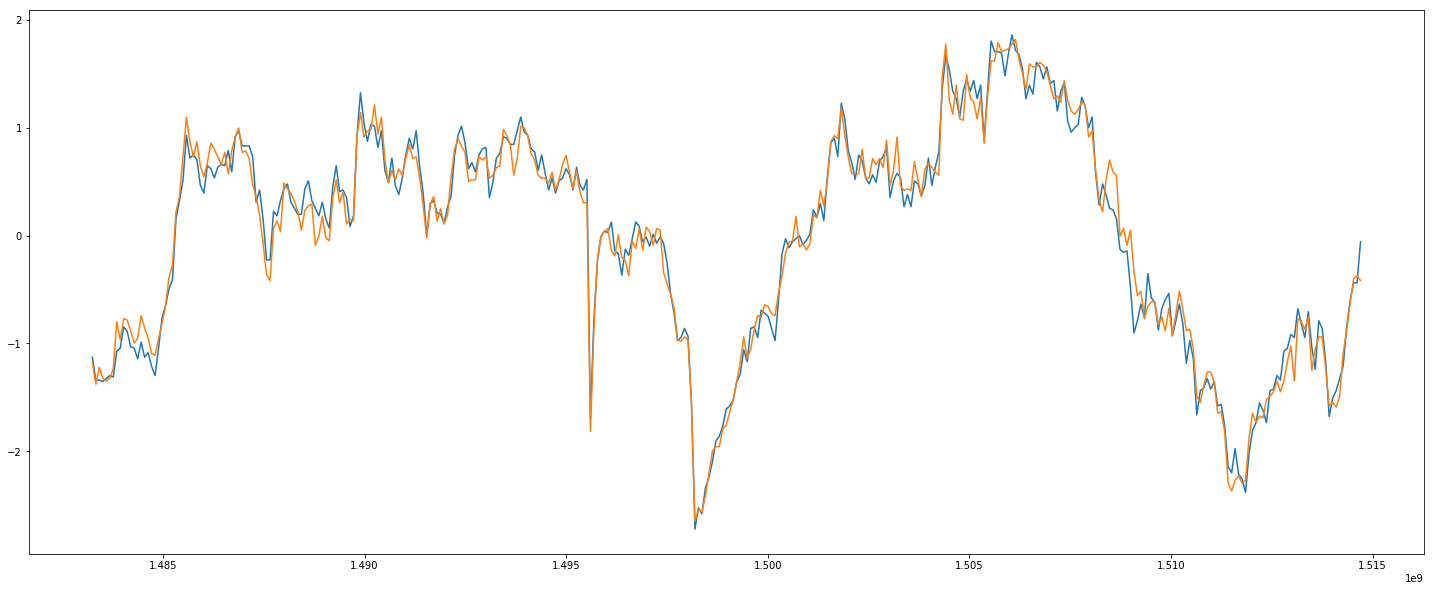

In [223]:
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(den.pivot.loc['StatTrak™ Glock-18 | Catacombs (Field-Tested) 8 January 2015'])
ax.plot(den.pivot.loc['StatTrak™ Glock-18 | Wraiths (Field-Tested) 17 September 2015'])

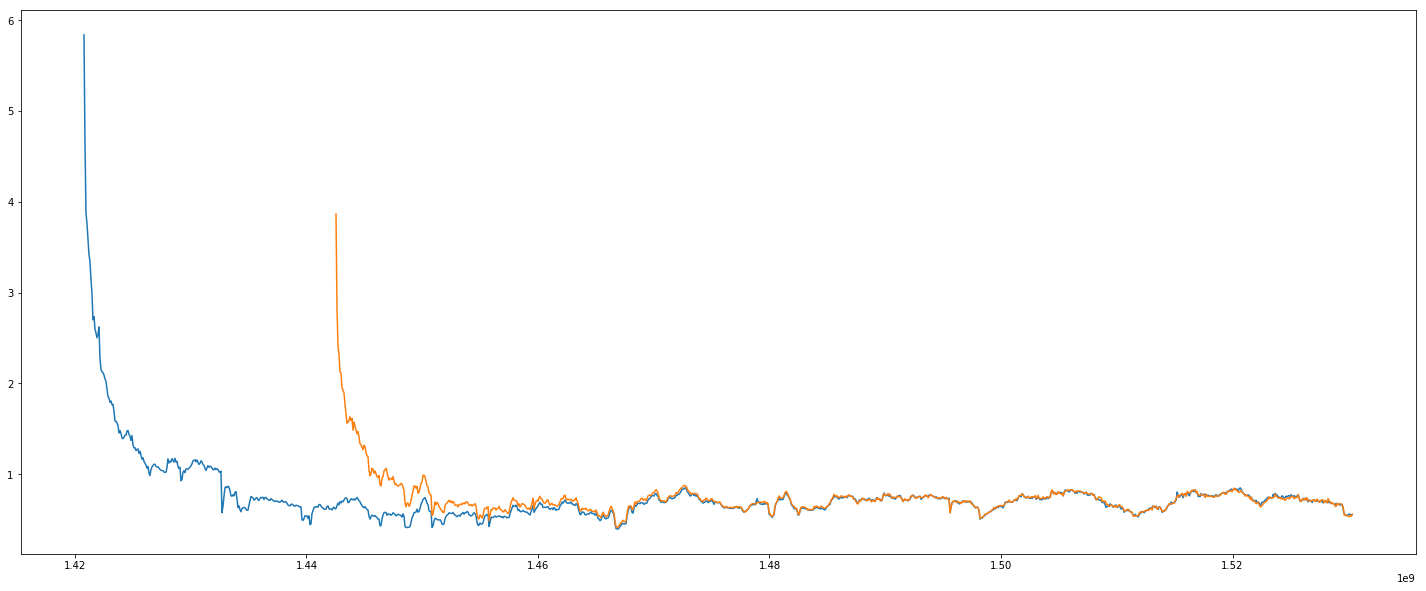

In [224]:
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(df[df.item_name=='StatTrak™ Glock-18 | Catacombs (Field-Tested)'].date, df[df.item_name=='StatTrak™ Glock-18 | Catacombs (Field-Tested)'].median_sell_price)
ax.plot(df[df.item_name=='StatTrak™ Glock-18 | Wraiths (Field-Tested)'].date, df[df.item_name=='StatTrak™ Glock-18 | Wraiths (Field-Tested)'].median_sell_price)

### Looking at date cutoffs for removing the first few days of sale

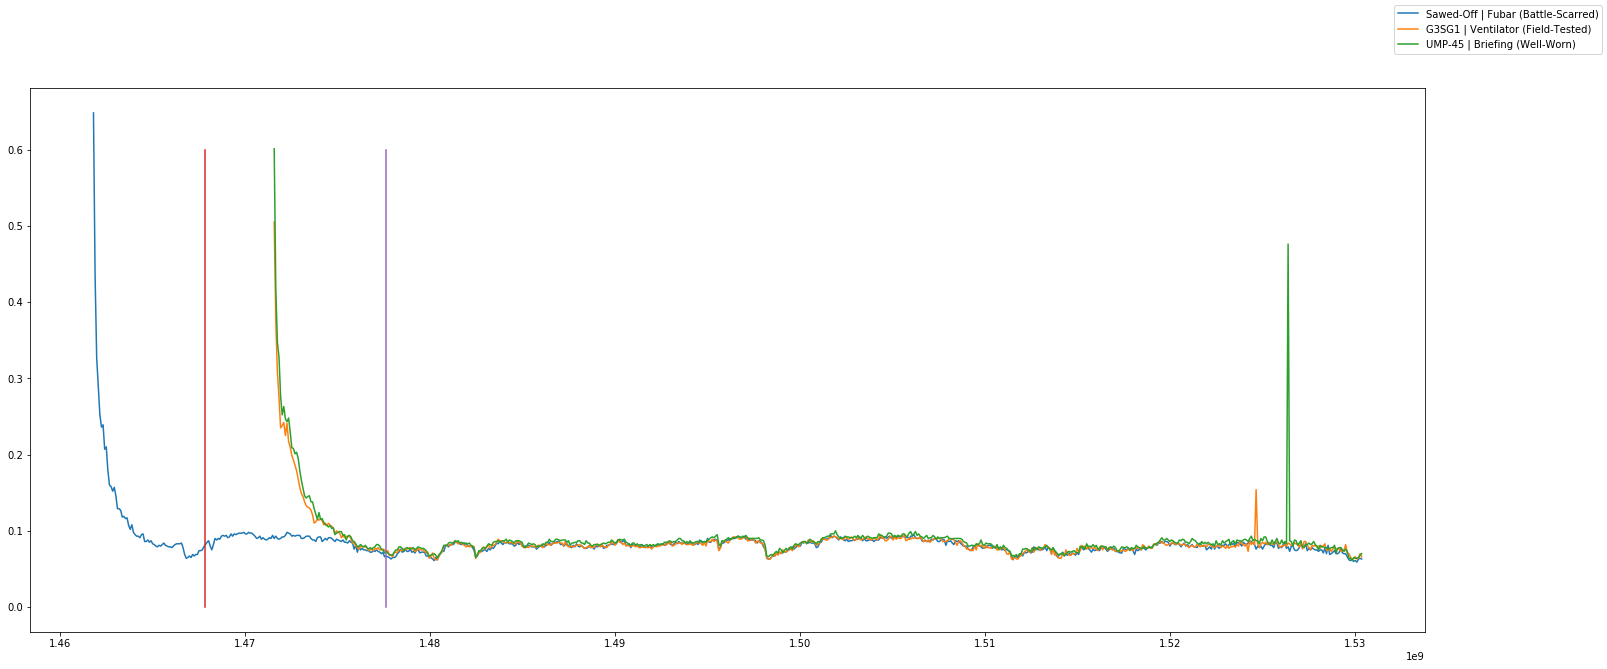

In [225]:
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)'].date, df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)'].median_sell_price, label='Sawed-Off | Fubar (Battle-Scarred)')
ax.plot(df[df.item_name=='G3SG1 | Ventilator (Field-Tested)'].date, df[df.item_name=='G3SG1 | Ventilator (Field-Tested)'].median_sell_price, label='G3SG1 | Ventilator (Field-Tested)')
ax.plot(df[df.item_name=='UMP-45 | Briefing (Well-Worn)'].date, df[df.item_name=='UMP-45 | Briefing (Well-Worn)'].median_sell_price, label='UMP-45 | Briefing (Well-Worn)')
ax.plot([df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)'].date.values[70]]*2, [0, 0.6])
ax.plot([df[df.item_name=='UMP-45 | Briefing (Well-Worn)'].date.values[70]]*2, [0, 0.6])
fig.legend()

---

### Preparing for anomaly detection three clustered items:

In [226]:
shotty = df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)']
gsg = df[df.item_name=='G3SG1 | Ventilator (Field-Tested)']
ump = df[df.item_name=='UMP-45 | Briefing (Well-Worn)']

In [227]:
shotty = shotty[shotty.days_since_release > 70]
shotty = shotty[['date', 'median_sell_price']].reset_index(drop=True)
shotty.columns = ['timestamp', 'count']
shotty.timestamp = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in shotty.timestamp]

gsg = gsg[gsg.days_since_release > 70]
gsg = gsg[['date', 'median_sell_price']].reset_index(drop=True)
gsg.columns = ['timestamp', 'count']
gsg.timestamp = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in gsg.timestamp]

ump = ump[ump.days_since_release > 70]
ump = ump[['date', 'median_sell_price']].reset_index(drop=True)
ump.columns = ['timestamp', 'count']
ump.timestamp = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in ump.timestamp]

Anomaly detection

In [228]:
results_shotty = detect_ts(shotty, max_anoms=0.05, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)
results_gsg = detect_ts(gsg, max_anoms=0.05, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)
results_ump = detect_ts(ump, max_anoms=0.05, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)

Text(0,0.5,'value')

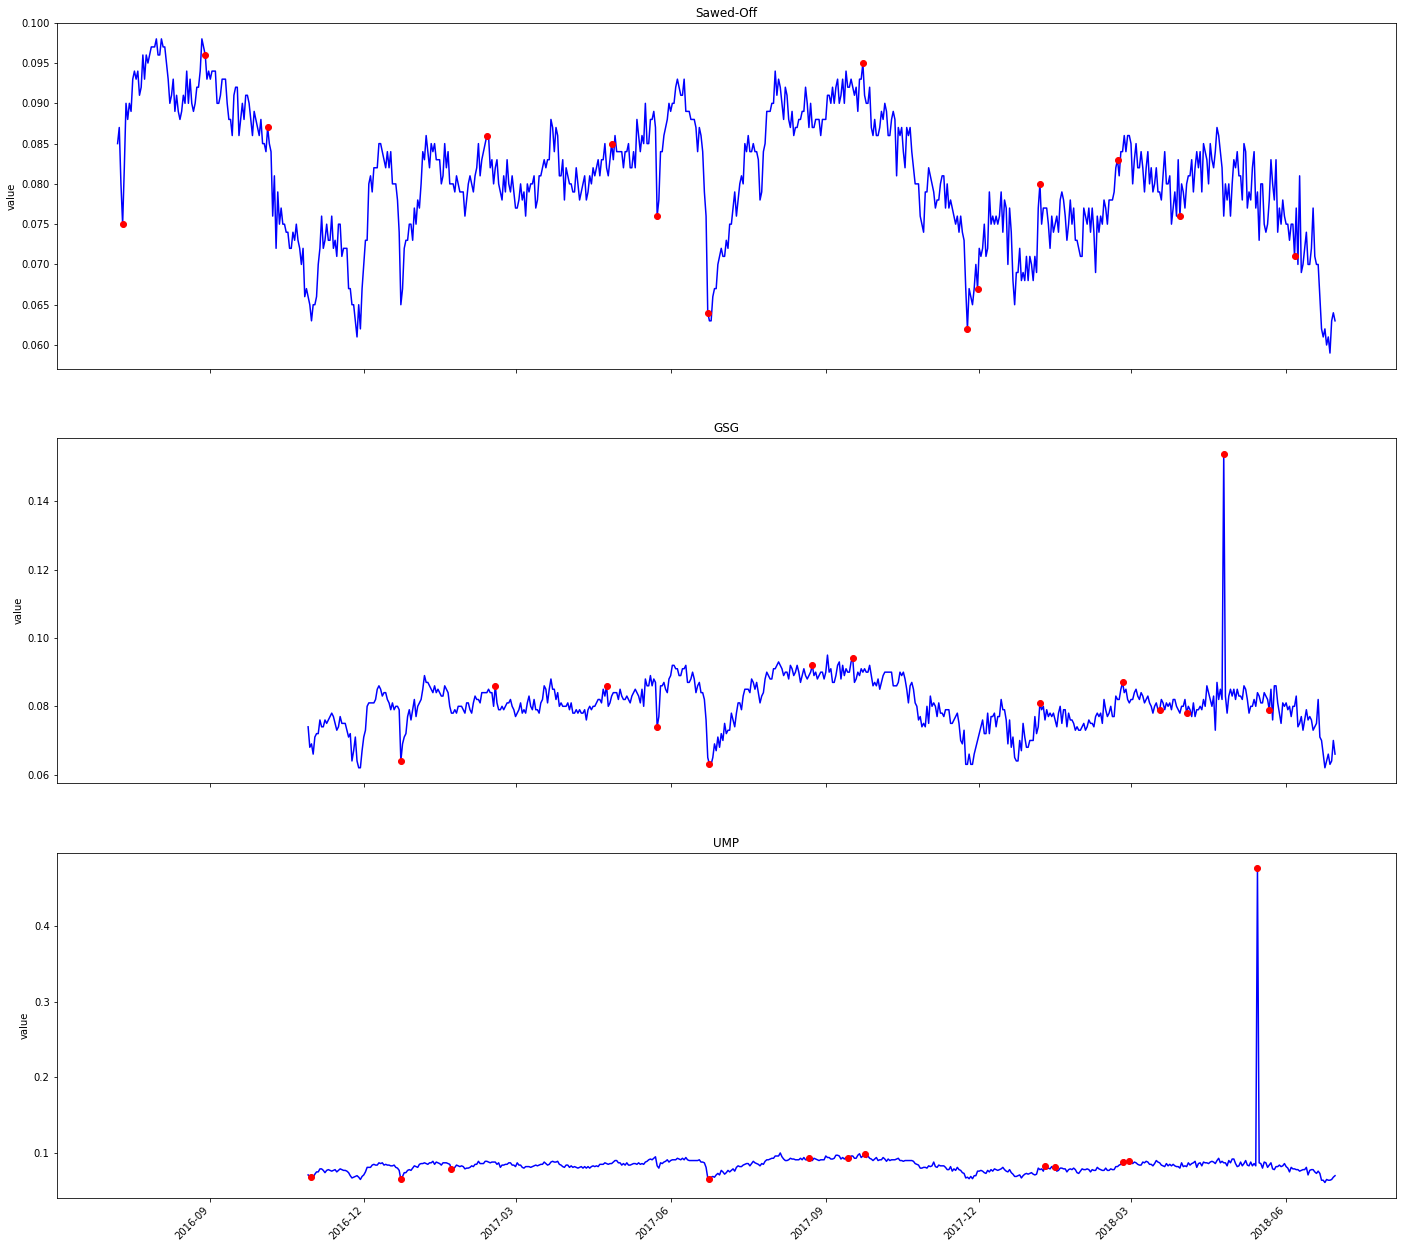

In [229]:
# make a nice plot
fig, ax = plt.subplots(3, 1, figsize=(24, 24), sharex=True)
fig.autofmt_xdate(rotation=45)

ax[0].plot(shotty['timestamp'], shotty['value'], 'b')
ax[0].plot(results_shotty['anoms'].index, results_shotty['anoms']['anoms'], 'ro')
ax[0].set_title('Sawed-Off')
ax[0].set_ylabel('value')

ax[1].plot(gsg['timestamp'], gsg['value'], 'b')
ax[1].plot(results_gsg['anoms'].index, results_gsg['anoms']['anoms'], 'ro')
ax[1].set_title('GSG')
ax[1].set_ylabel('value')

ax[2].plot(ump['timestamp'], ump['value'], 'b')
ax[2].plot(results_ump['anoms'].index, results_ump['anoms']['anoms'], 'ro')
ax[2].set_title('UMP')
ax[2].set_ylabel('value')

In [230]:
results_shotty['anoms'].index

DatetimeIndex(['2016-07-11', '2016-08-29', '2016-10-05', '2017-02-12',
               '2017-04-27', '2017-05-24', '2017-06-23', '2017-09-23',
               '2017-11-24', '2017-11-30', '2018-01-06', '2018-02-21',
               '2018-03-30', '2018-06-06'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

#### Check for common anomaly dates

In [231]:
anoms = Counter()
anoms.update(results_shotty['anoms'].index)
anoms.update(results_gsg['anoms'].index)
anoms.update(results_ump['anoms'].index)

In [232]:
sorted(anoms.most_common(5))

[(Timestamp('2016-12-23 00:00:00'), 2),
 (Timestamp('2017-05-24 00:00:00'), 2),
 (Timestamp('2017-06-24 00:00:00'), 2),
 (Timestamp('2018-01-06 00:00:00'), 2),
 (Timestamp('2018-02-24 00:00:00'), 2)]

### Where I am:
  * Ideally I don't hit the first day of the arbitrary cutoff (only detect last... all but day 1)
  * Need to give the dates a little wiggle room (change number of anomalies detected?)


---

### Running anomaly detection on n random items and plotting. Then adding the list of anomaly dates to a Counter.

In [233]:
anomaly_df = df[df.gun_bool]
# anomaly_df = anomaly_df[anomaly_df.days_since_release > 70]
anomaly_df = mask_mins(anomaly_df, 0.1, 50)
anomaly_df['timestamp'] = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in anomaly_df.date]
anomaly_df = anomaly_df[anomaly_df.release_date != '15 February 2018'] # not enough points
guns = anomaly_df.item_name.unique()

In [234]:
hold_df = anomaly_df.copy()

[(Timestamp('2017-05-24 00:00:00'), 5),
 (Timestamp('2017-05-25 00:00:00'), 3),
 (Timestamp('2017-11-23 00:00:00'), 3),
 (Timestamp('2017-03-22 00:00:00'), 3),
 (Timestamp('2017-03-23 00:00:00'), 3),
 (Timestamp('2016-11-25 00:00:00'), 3),
 (Timestamp('2016-11-26 00:00:00'), 3),
 (Timestamp('2016-11-27 00:00:00'), 3),
 (Timestamp('2016-11-28 00:00:00'), 3),
 (Timestamp('2017-03-19 00:00:00'), 3),
 (Timestamp('2017-11-26 00:00:00'), 3),
 (Timestamp('2017-03-28 00:00:00'), 2),
 (Timestamp('2017-09-19 00:00:00'), 2),
 (Timestamp('2017-09-20 00:00:00'), 2),
 (Timestamp('2016-06-23 00:00:00'), 2),
 (Timestamp('2016-06-24 00:00:00'), 2),
 (Timestamp('2016-06-25 00:00:00'), 2),
 (Timestamp('2016-06-26 00:00:00'), 2),
 (Timestamp('2016-06-27 00:00:00'), 2),
 (Timestamp('2016-10-09 00:00:00'), 2)]

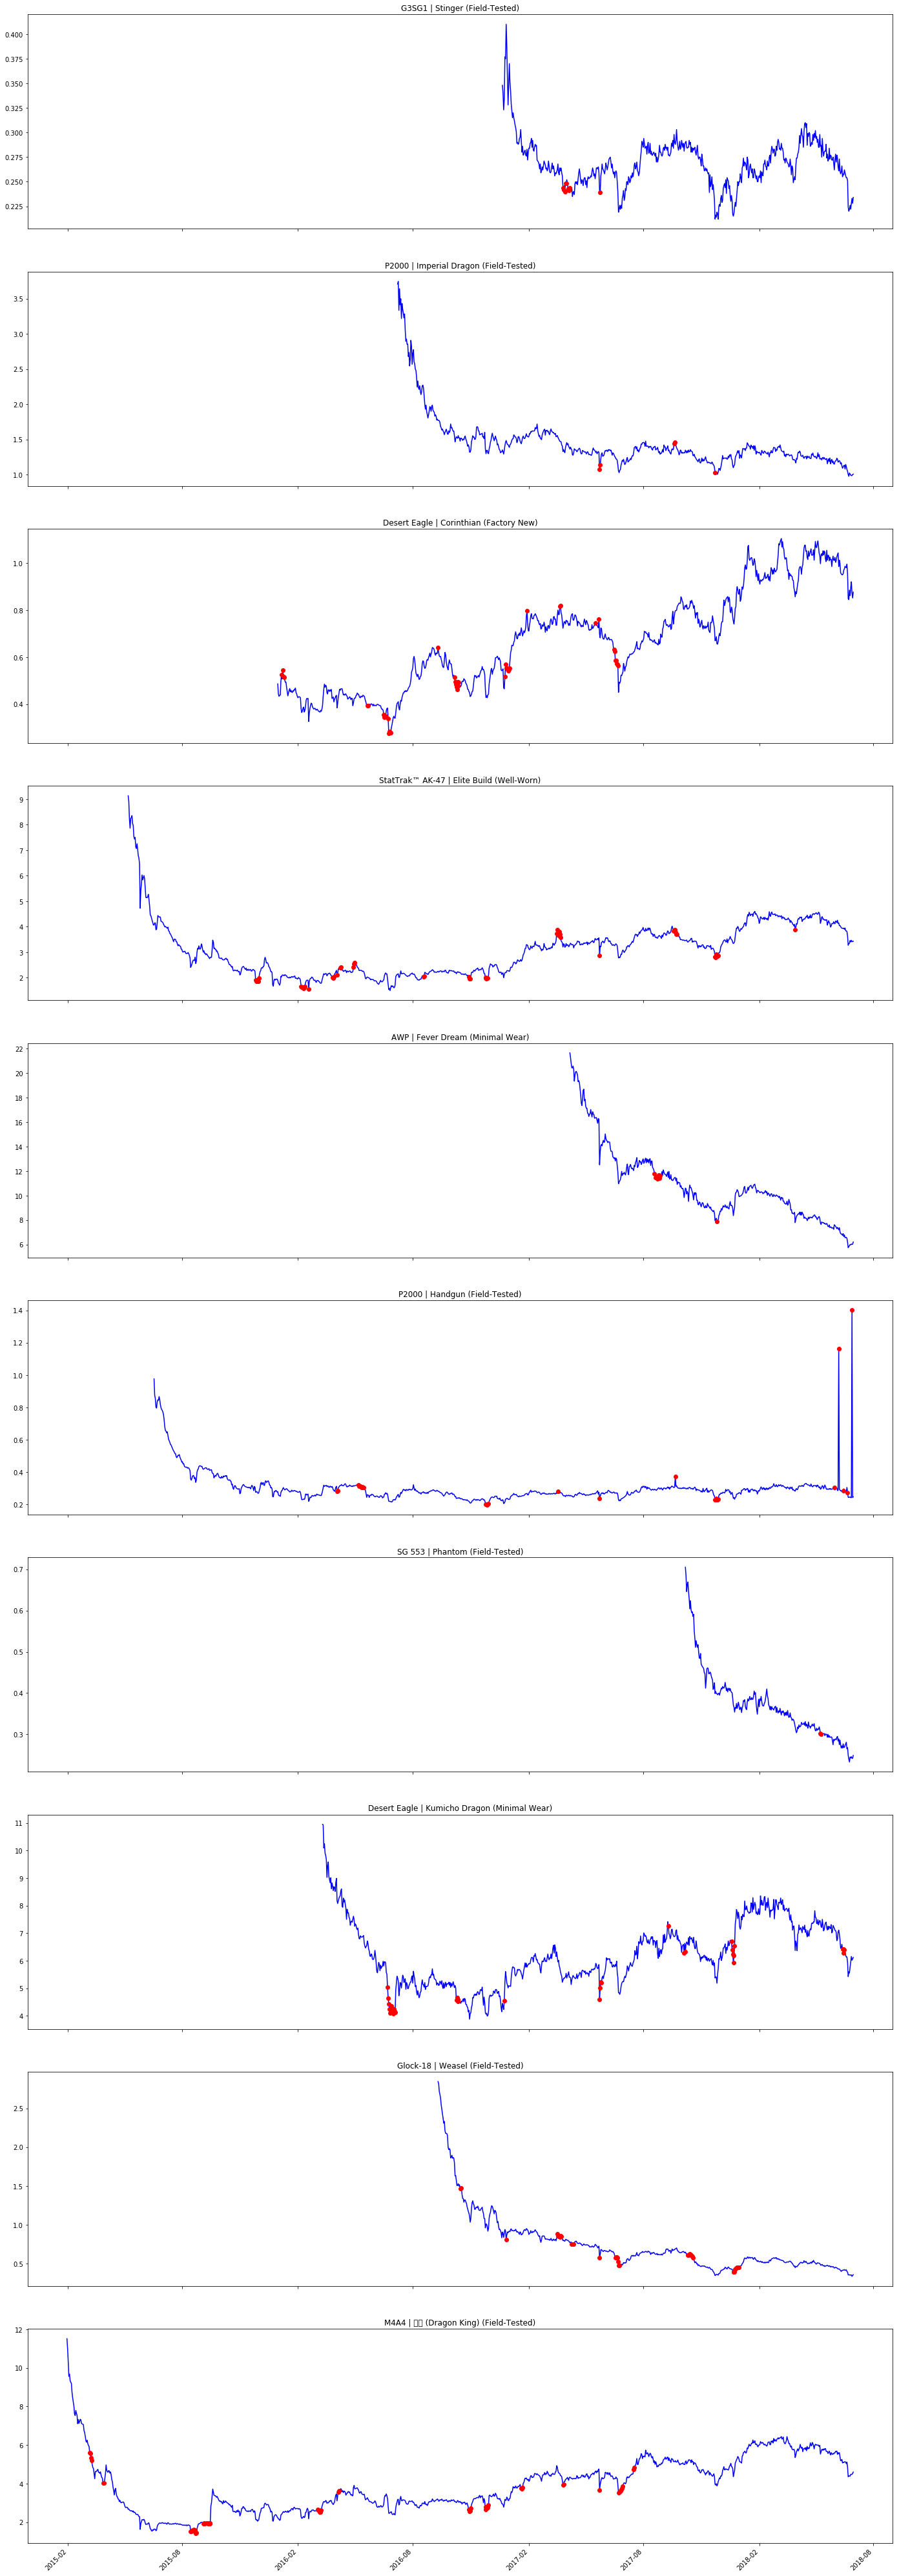

In [235]:
n_timeseries = 10
fig, ax = plt.subplots(n_timeseries, 1, figsize=(24, 8*n_timeseries), sharex=True)
fig.autofmt_xdate(rotation=45)
anom_counter = Counter()
anomaly_df = hold_df[hold_df.days_since_release > 21]
for i, gun in enumerate(np.random.choice(guns, n_timeseries, replace=False)):
    temp_df = anomaly_df[anomaly_df.item_name == gun]
    temp_df = temp_df[['timestamp', 'median_sell_price']].reset_index(drop=True)
    results = detect_ts(temp_df, max_anoms=0.25, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=5)
    ax[i].plot(temp_df['timestamp'], temp_df['value'], 'b')
    ax[i].plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
    ax[i].set_title(gun)
    anom_counter.update(results['anoms'].index[1:])
anom_counter.most_common(20)

---

### Testing USP-S | Para Green (Field-Tested) with different detect_ts parameters

Text(0.5,1,'USP-S | Para Green (Field-Tested)')

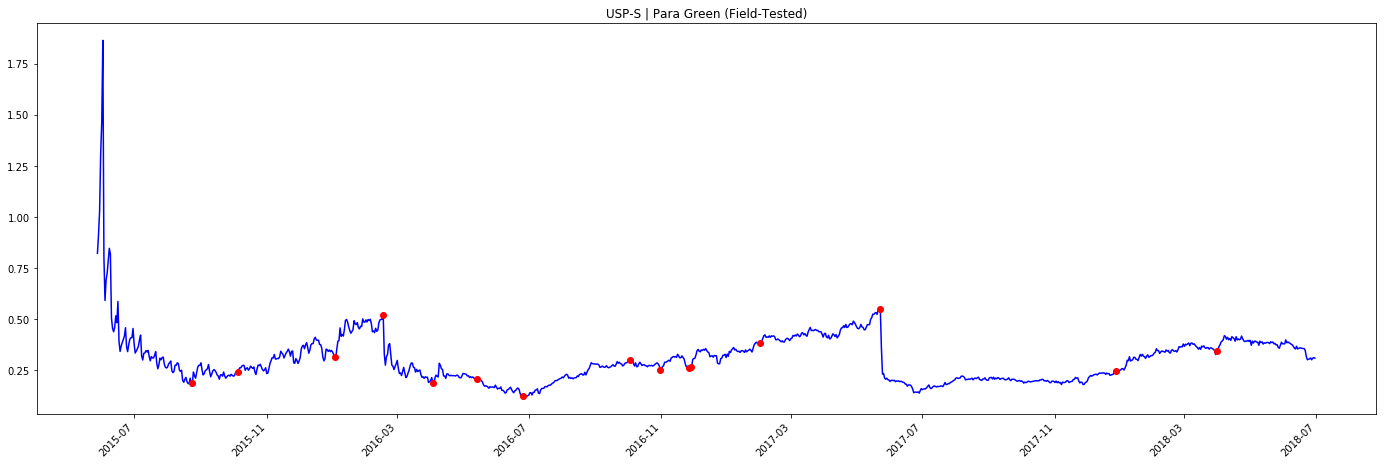

In [236]:
n_timeseries = 1
fig, ax = plt.subplots(figsize=(24, 8*n_timeseries), sharex=True)
fig.autofmt_xdate(rotation=45)
anomaly_df = hold_df[hold_df.days_since_release > 0]

gun = 'USP-S | Para Green (Field-Tested)'
temp_df = anomaly_df[anomaly_df.item_name == gun]
temp_df = temp_df[['timestamp', 'median_sell_price']].reset_index(drop=True)
results = detect_ts(temp_df, max_anoms=0.05, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)
ax.plot(temp_df['timestamp'], temp_df['value'], 'b')
ax.plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
ax.set_title(gun)

In [237]:
print(*[x.date() for x in results['anoms'].index], sep='\n')

2015-08-24
2015-10-05
2016-01-03
2016-02-17
2016-04-03
2016-05-14
2016-06-26
2016-10-03
2016-10-31
2016-11-27
2016-11-28
2017-01-31
2017-05-23
2017-12-28
2018-03-31


Text(0.5,1,'USP-S | Para Green (Field-Tested)')

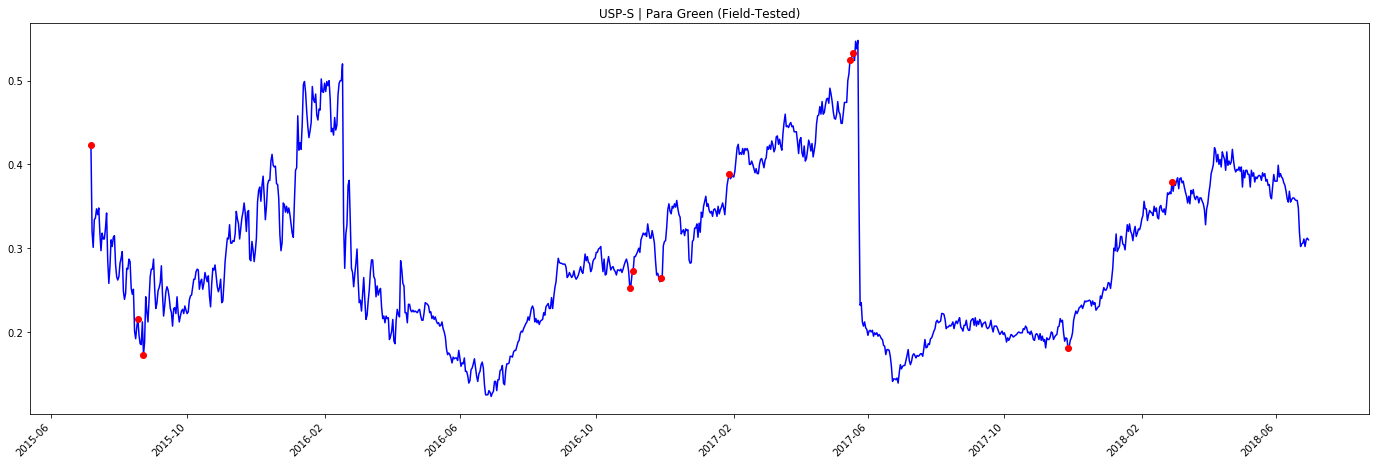

In [238]:
n_timeseries = 1
fig, ax = plt.subplots(figsize=(24, 8*n_timeseries), sharex=True)
fig.autofmt_xdate(rotation=45)
anomaly_df = hold_df[hold_df.days_since_release > 40]

gun = 'USP-S | Para Green (Field-Tested)'
temp_df = anomaly_df[anomaly_df.item_name == gun]
temp_df = temp_df[['timestamp', 'median_sell_price']].reset_index(drop=True)
results = detect_ts(temp_df, max_anoms=0.05, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)
ax.plot(temp_df['timestamp'], temp_df['value'], 'b')
ax.plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
ax.set_title(gun)

In [239]:
print(*[x.date() for x in results['anoms'].index], sep='\n')

2015-07-07
2015-08-18
2015-08-23
2016-10-31
2016-11-03
2016-11-28
2017-01-28
2017-05-16
2017-05-19
2017-11-27
2018-02-28


---

### Run anomaly detection over many items and combine results

In [240]:
n_timeseries = 100
anom_counter = Counter()
anom_list = []
for i, gun in enumerate(np.random.choice(guns, n_timeseries, replace=False)):
    temp_df = anomaly_df[anomaly_df.item_name == gun]
    temp_df = temp_df[['timestamp', 'median_sell_price']].reset_index(drop=True)
    results = detect_ts(temp_df, max_anoms=0.2, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)
    anom_list += results['anoms'].index[1:]
    anom_counter.update(results['anoms'].index[1:])
anom_counter.most_common(20)

[(Timestamp('2017-05-24 00:00:00'), 62),
 (Timestamp('2016-11-26 00:00:00'), 49),
 (Timestamp('2016-11-25 00:00:00'), 42),
 (Timestamp('2016-11-27 00:00:00'), 42),
 (Timestamp('2016-11-24 00:00:00'), 39),
 (Timestamp('2016-11-28 00:00:00'), 38),
 (Timestamp('2016-02-18 00:00:00'), 36),
 (Timestamp('2017-05-25 00:00:00'), 35),
 (Timestamp('2016-02-10 00:00:00'), 33),
 (Timestamp('2018-06-23 00:00:00'), 32),
 (Timestamp('2016-06-24 00:00:00'), 29),
 (Timestamp('2016-11-29 00:00:00'), 29),
 (Timestamp('2016-06-25 00:00:00'), 28),
 (Timestamp('2016-01-03 00:00:00'), 27),
 (Timestamp('2018-03-30 00:00:00'), 26),
 (Timestamp('2016-01-02 00:00:00'), 26),
 (Timestamp('2015-08-23 00:00:00'), 25),
 (Timestamp('2015-08-24 00:00:00'), 25),
 (Timestamp('2016-01-04 00:00:00'), 25),
 (Timestamp('2016-10-31 00:00:00'), 25)]

### Account for anomaly detection being off by a few days

In [241]:
anom_delta_dict = {}
for day in set(anom_list):
    start, end = day - datetime.timedelta(3), day + datetime.timedelta(3)
    anom_delta_dict[day]= sum(x >= start and x <= end for x in anom_list)

In [242]:
sorted(anom_delta_dict.items(), key=lambda x: x[1], reverse=True)[:30]

[(Timestamp('2016-11-27 00:00:00'), 248),
 (Timestamp('2016-11-26 00:00:00'), 245),
 (Timestamp('2016-11-25 00:00:00'), 217),
 (Timestamp('2016-11-28 00:00:00'), 209),
 (Timestamp('2016-11-24 00:00:00'), 181),
 (Timestamp('2017-05-22 00:00:00'), 173),
 (Timestamp('2017-05-23 00:00:00'), 168),
 (Timestamp('2016-11-29 00:00:00'), 167),
 (Timestamp('2017-05-24 00:00:00'), 159),
 (Timestamp('2017-05-21 00:00:00'), 146),
 (Timestamp('2017-05-25 00:00:00'), 143),
 (Timestamp('2018-06-25 00:00:00'), 142),
 (Timestamp('2016-02-10 00:00:00'), 140),
 (Timestamp('2016-02-09 00:00:00'), 139),
 (Timestamp('2016-11-23 00:00:00'), 139),
 (Timestamp('2017-05-26 00:00:00'), 131),
 (Timestamp('2018-06-26 00:00:00'), 127),
 (Timestamp('2018-06-24 00:00:00'), 127),
 (Timestamp('2016-02-08 00:00:00'), 127),
 (Timestamp('2016-02-11 00:00:00'), 125),
 (Timestamp('2016-11-30 00:00:00'), 118),
 (Timestamp('2017-05-27 00:00:00'), 117),
 (Timestamp('2015-08-21 00:00:00'), 110),
 (Timestamp('2015-08-22 00:00:00')

## Let's try with more than just guns

In [243]:
with open('data/csgo_df.pkl', 'rb') as f:
    csfull = pickle.load(f)

In [244]:
csfull['days_since_release'] = np.nan
csfull['days_since_release'] = csfull.groupby('item_name').transform(lambda x: np.arange(len(x)))

In [245]:
csfull['num_sale_days'] = csfull.groupby('item_name')['days_since_release'].transform('max')
csfull['desc'] = csfull['item_name'] + ' ' + csfull['release_date']

In [246]:
anomaly_full = csfull[csfull.days_since_release > 30]

In [247]:
anomaly_full = mask_mins(anomaly_full, 0.1, 50)
anomaly_full['timestamp'] = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in anomaly_full.date]
anomaly_full = anomaly_full[anomaly_full.release_date != '15 February 2018'] # not enough points
items = anomaly_full.item_name.unique()

In [248]:
n_timeseries = 100
anom_counter = Counter()
anom_list = []
for i, item in enumerate(np.random.choice(items, n_timeseries, replace=False)):
    temp_df = anomaly_full[anomaly_full.item_name == item]
    temp_df = temp_df[['timestamp', 'median_sell_price']].reset_index(drop=True)
    results = detect_ts(temp_df, max_anoms=0.2, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)
    anom_list += results['anoms'].index[1:]
    anom_counter.update(results['anoms'].index[1:])

In [249]:
anom_delta_dict = {}
for day in set(anom_list):
    start, end = day - datetime.timedelta(3), day + datetime.timedelta(3)
    anom_delta_dict[day]= sum(x >= start and x <= end for x in anom_list)
sorted(anom_delta_dict.items(), key=lambda x: x[1], reverse=True)[:30]

[(Timestamp('2017-11-26 00:00:00'), 173),
 (Timestamp('2017-11-25 00:00:00'), 171),
 (Timestamp('2017-11-27 00:00:00'), 151),
 (Timestamp('2017-11-24 00:00:00'), 151),
 (Timestamp('2015-11-28 00:00:00'), 144),
 (Timestamp('2015-11-29 00:00:00'), 144),
 (Timestamp('2017-05-27 00:00:00'), 133),
 (Timestamp('2017-11-23 00:00:00'), 130),
 (Timestamp('2017-05-26 00:00:00'), 129),
 (Timestamp('2015-11-30 00:00:00'), 128),
 (Timestamp('2015-11-27 00:00:00'), 127),
 (Timestamp('2017-11-28 00:00:00'), 125),
 (Timestamp('2017-05-25 00:00:00'), 123),
 (Timestamp('2017-05-24 00:00:00'), 120),
 (Timestamp('2017-05-23 00:00:00'), 118),
 (Timestamp('2017-06-24 00:00:00'), 114),
 (Timestamp('2017-05-22 00:00:00'), 112),
 (Timestamp('2017-06-25 00:00:00'), 111),
 (Timestamp('2017-06-23 00:00:00'), 110),
 (Timestamp('2015-11-26 00:00:00'), 105),
 (Timestamp('2016-11-26 00:00:00'), 105),
 (Timestamp('2016-11-27 00:00:00'), 103),
 (Timestamp('2017-11-29 00:00:00'), 102),
 (Timestamp('2017-06-26 00:00:00')

In [250]:
anomaly_full = anomaly_full[anomaly_full.days_since_release > 70]
anomaly_full = mask_mins(anomaly_full, 0.1, 50)
anomaly_full['timestamp'] = [np.datetime64(datetime.datetime.fromtimestamp(t).date()) for t in anomaly_full.date]
anomaly_full = anomaly_full[anomaly_full.release_date != '15 February 2018'] # not enough points

In [251]:
hold_df = anomaly_full.copy()

[(Timestamp('2017-11-27 00:00:00'), 5),
 (Timestamp('2017-11-23 00:00:00'), 4),
 (Timestamp('2017-11-24 00:00:00'), 4),
 (Timestamp('2017-11-25 00:00:00'), 4),
 (Timestamp('2017-11-26 00:00:00'), 4),
 (Timestamp('2017-11-28 00:00:00'), 4),
 (Timestamp('2018-03-30 00:00:00'), 3),
 (Timestamp('2018-04-02 00:00:00'), 3),
 (Timestamp('2018-04-03 00:00:00'), 3),
 (Timestamp('2018-06-26 00:00:00'), 3),
 (Timestamp('2016-09-01 00:00:00'), 2),
 (Timestamp('2017-03-19 00:00:00'), 2),
 (Timestamp('2017-03-21 00:00:00'), 2),
 (Timestamp('2017-05-24 00:00:00'), 2),
 (Timestamp('2017-10-21 00:00:00'), 2),
 (Timestamp('2017-10-22 00:00:00'), 2),
 (Timestamp('2017-10-23 00:00:00'), 2),
 (Timestamp('2017-10-24 00:00:00'), 2),
 (Timestamp('2017-12-29 00:00:00'), 2),
 (Timestamp('2017-12-30 00:00:00'), 2)]

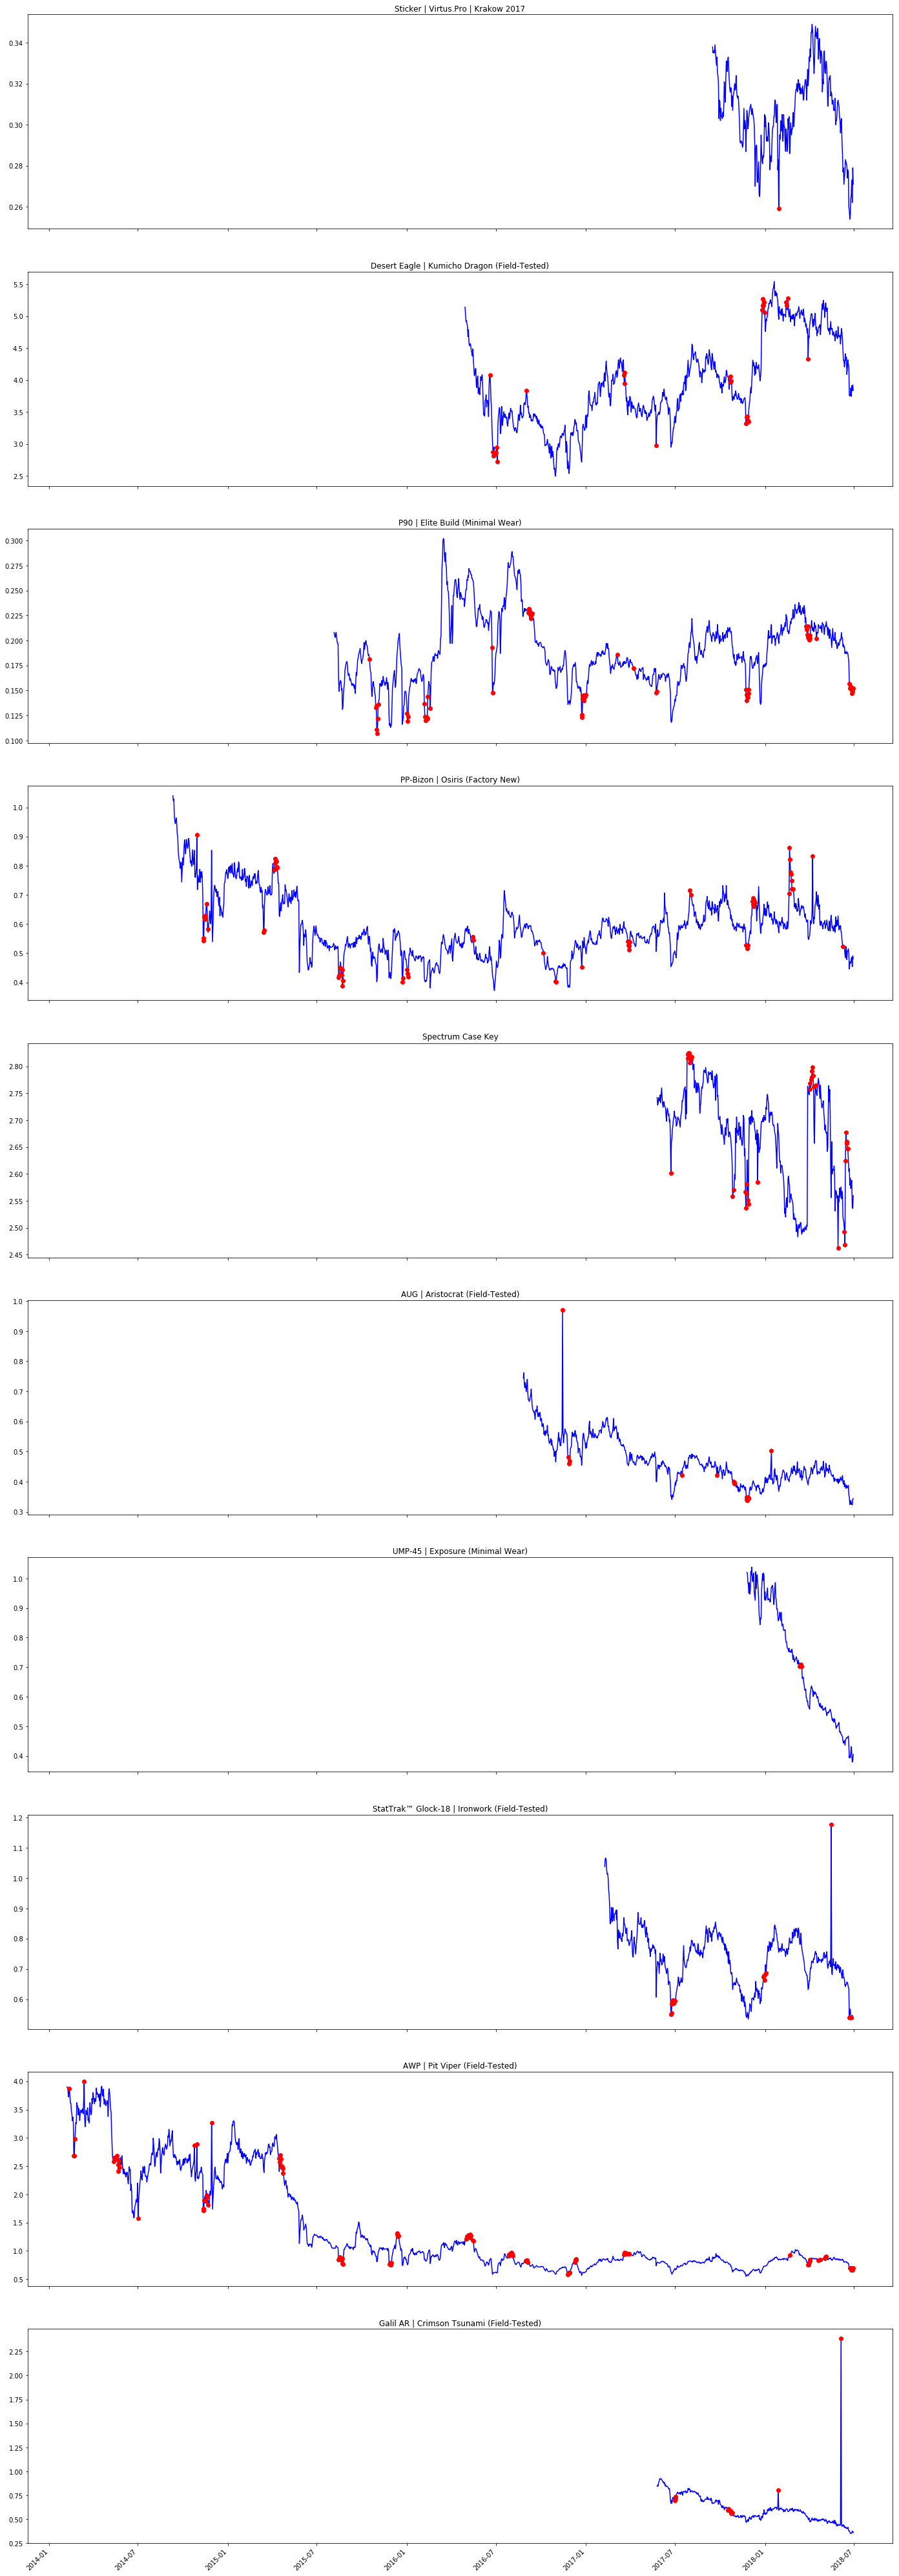

In [252]:
n_timeseries = 10
fig, ax = plt.subplots(n_timeseries, 1, figsize=(24, 8*n_timeseries), sharex=True)
fig.autofmt_xdate(rotation=45)
anom_counter = Counter()
anomaly_full = hold_df[hold_df.days_since_release > 21]
for i, item in enumerate(np.random.choice(items, n_timeseries, replace=False)):
    temp_df = anomaly_full[anomaly_full.item_name == item]
    temp_df = temp_df[['timestamp', 'median_sell_price']].reset_index(drop=True)
    results = detect_ts(temp_df, max_anoms=0.25, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=5)
    ax[i].plot(temp_df['timestamp'], temp_df['value'], 'b')
    ax[i].plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
    ax[i].set_title(item)
    anom_counter.update(results['anoms'].index[1:])
anom_counter.most_common(20)